<a href="https://colab.research.google.com/github/RehanAfzalkhan/HW-2-Deep-Learning-and-its-Applications-Neural-Networks/blob/main/CSI_5140_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0) Setup & Imports

In [2]:
# Colab-friendly imports
import os, csv, shutil
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# For MNIST
from tensorflow.keras.datasets import mnist

# PCA
from sklearn.decomposition import PCA


1) Load & Prepare MNIST (training set only)

In [3]:
# Load MNIST
(x_train, y_train), _ = mnist.load_data()

# Flatten 28x28 -> 784 and normalize to [0,1]
x_train = x_train.reshape((x_train.shape[0], -1)).astype("float32") / 255.0

print("x_train shape:", x_train.shape)  # (60000, 784)
print("y_train shape:", y_train.shape)  # (60000,)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 784)
y_train shape: (60000,)


2) Fit GLOBAL PCA (top 30 components) for ALL digits (Part 1)

In [4]:
# Fit global PCA on the full training set
pca30 = PCA(n_components=30, svd_solver="randomized", random_state=0)
pca30.fit(x_train)

eigenvalues = pca30.explained_variance_
components_30 = pca30.components_   # (30, 784)
mean_vec = pca30.mean_              # (784,)

print("Top-30 eigenvalues (first 5):", eigenvalues[:5])
print("components_30 shape:", components_30.shape)


Top-30 eigenvalues (first 5): [5.1168647 3.7413943 3.252713  2.8416185 2.567116 ]
components_30 shape: (30, 784)


3) Create results folder (timestamped)

In [5]:
# Timestamped root directory so reruns won't overwrite previous results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ROOT = f"PCA_HW2_results_{timestamp}"
os.makedirs(ROOT, exist_ok=True)

print("Results folder:", ROOT)


Results folder: PCA_HW2_results_20251006_145357


4) Part 1 — Save Top-30 Eigenvalues Plot + Eigenvectors Grid

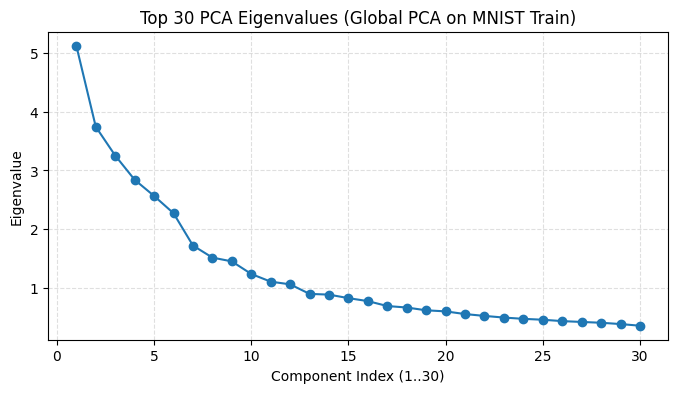

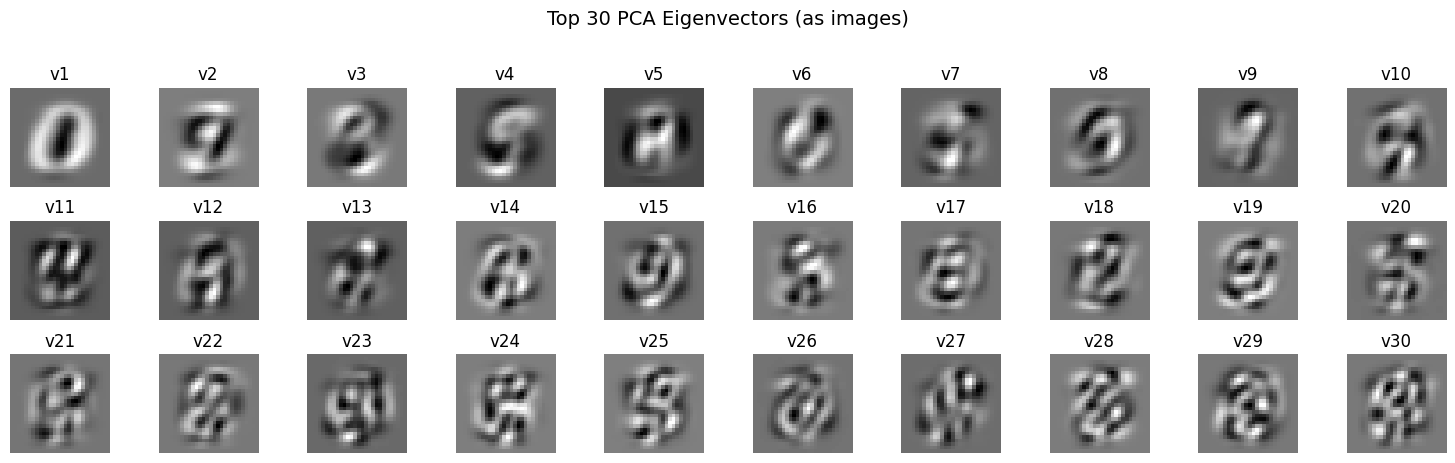

Saved Part 1 figures:
 • PCA_HW2_results_20251006_145357/part1_top30_eigenvalues.png
 • PCA_HW2_results_20251006_145357/part1_top30_eigenvectors_grid.png


In [6]:
# ---- Plot top 30 eigenvalues
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, 31), eigenvalues, marker='o')
plt.title("Top 30 PCA Eigenvalues (Global PCA on MNIST Train)")
plt.xlabel("Component Index (1..30)")
plt.ylabel("Eigenvalue")
plt.grid(True, linestyle="--", alpha=0.4)
eigs_path = os.path.join(ROOT, "part1_top30_eigenvalues.png")
plt.savefig(eigs_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close()

# ---- Display & save top 30 eigenvectors as a 3x10 grid (images 28x28)
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))
fig.suptitle("Top 30 PCA Eigenvectors (as images)", y=1.02, fontsize=14)

for i in range(30):
    r, c = divmod(i, 10)
    ax = axes[r, c]
    ax.imshow(components_30[i].reshape(28,28), cmap='gray')
    ax.set_title(f"v{i+1}")
    ax.axis('off')

grid_path = os.path.join(ROOT, "part1_top30_eigenvectors_grid.png")
plt.tight_layout()
plt.savefig(grid_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

print("Saved Part 1 figures:")
print(" •", eigs_path)
print(" •", grid_path)


5) Helper — Reconstruct using top-k global components + MSE

In [7]:
def reconstruct_with_k(sample_flat_784, k, mean_vec, components_30):
    """
    Reconstructs a single sample using the first k components from the *global* PCA.
    Returns (reconstructed_image_28x28, mse_float)
    """
    x_centered = sample_flat_784 - mean_vec         # (784,)
    Vk = components_30[:k, :]                       # (k, 784)
    coeffs = Vk @ x_centered                        # (k,)
    recon = mean_vec + coeffs @ Vk                  # (784,)
    mse = float(np.mean((sample_flat_784 - recon) ** 2))
    return recon.reshape(28, 28), mse


6) Part 2 — Per-digit (0..9) reconstructions for a/b/c/d (k=2,5,20,30)

This cell:

Picks one example per digit (the first occurrence).

Saves per-k reconstructions (digitX_k2.png, etc.), the original, a 1×5 grid per digit, and logs MSEs to mse_summary.csv.

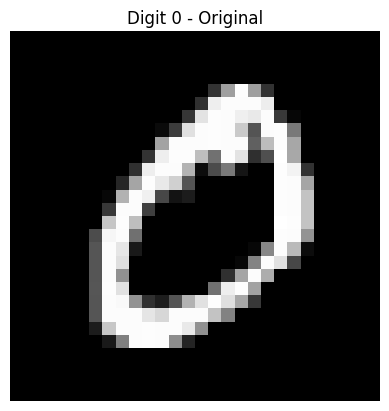

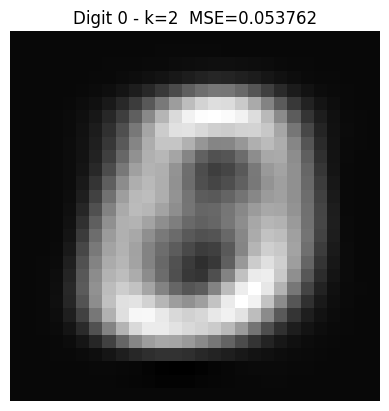

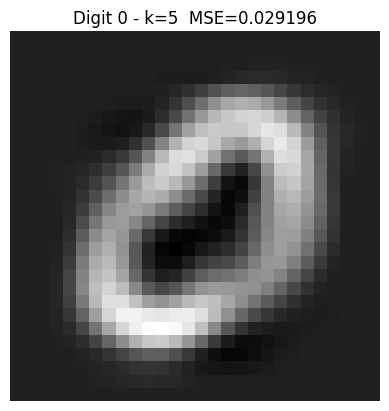

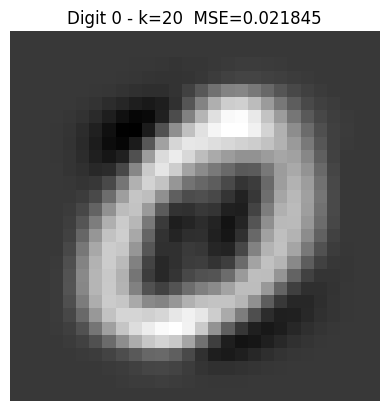

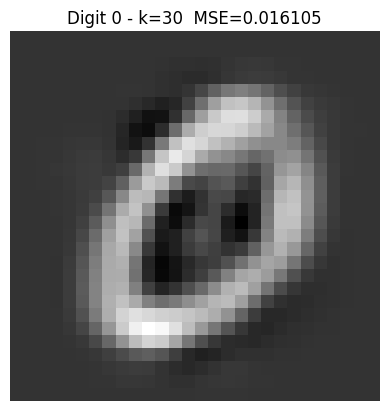

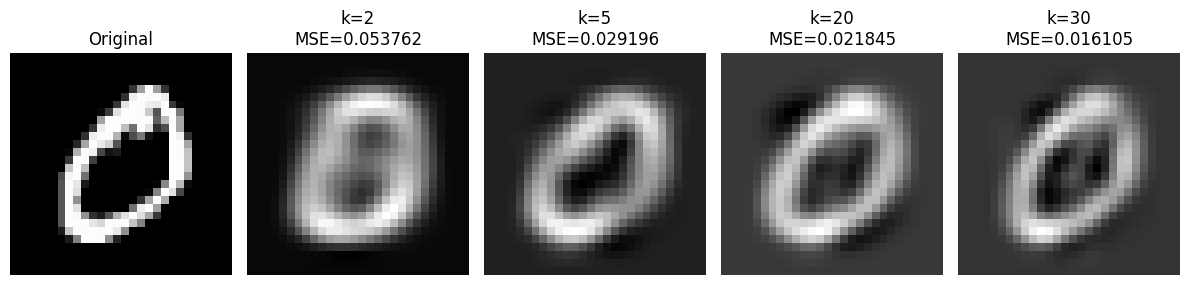

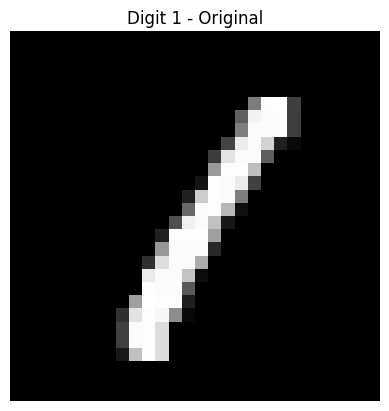

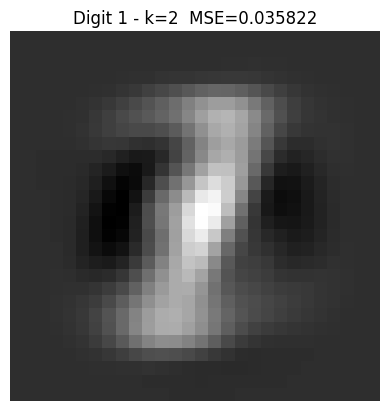

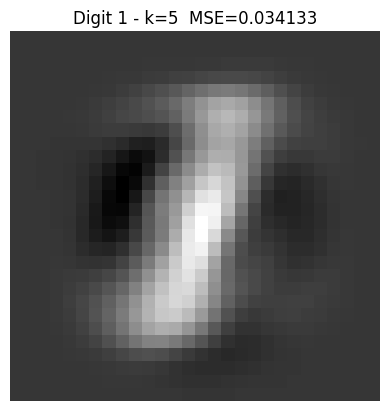

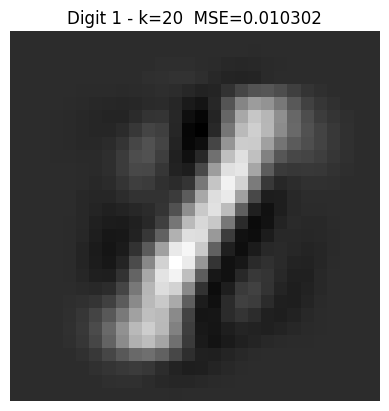

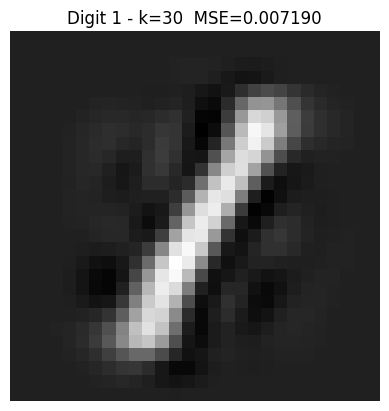

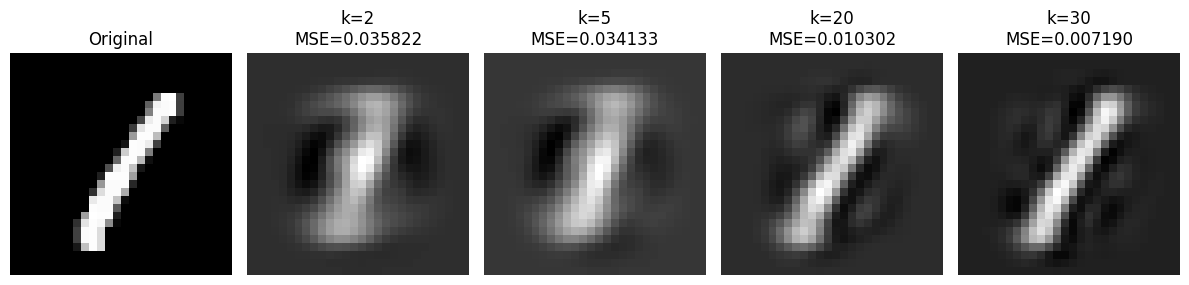

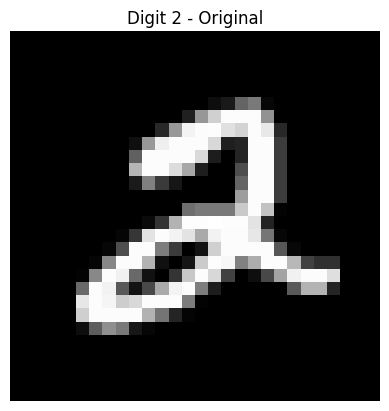

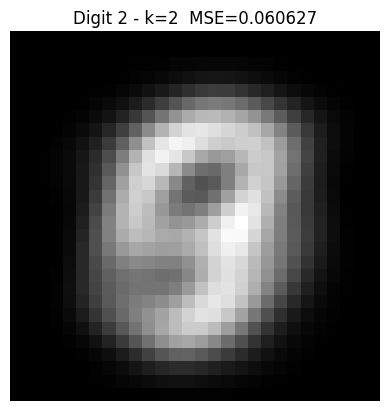

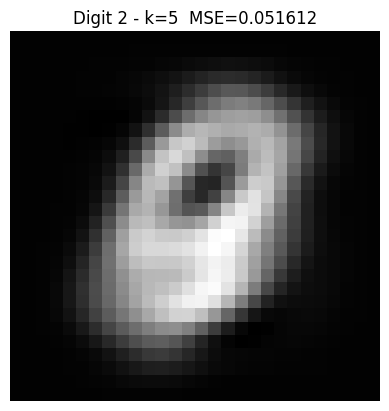

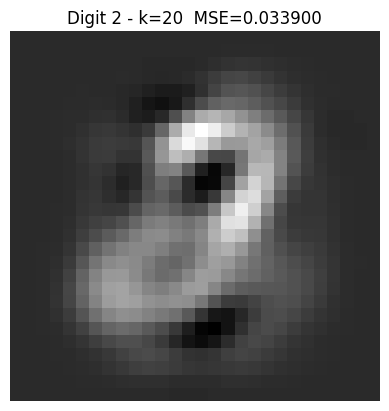

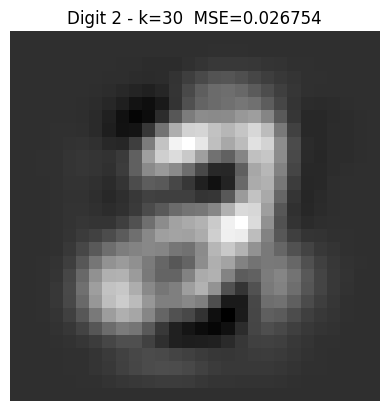

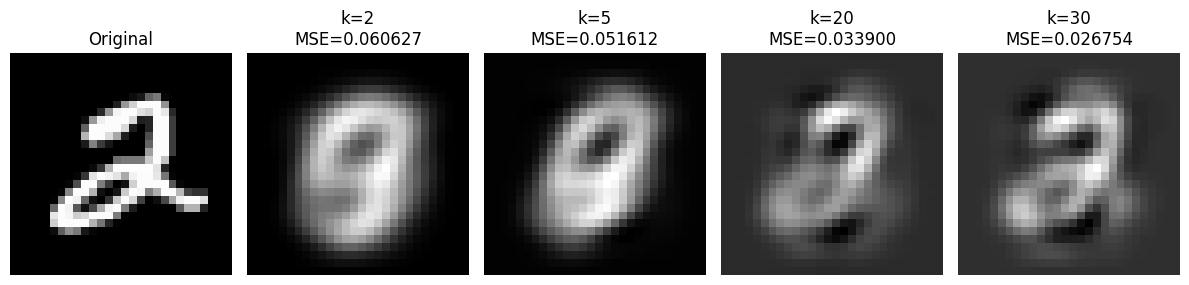

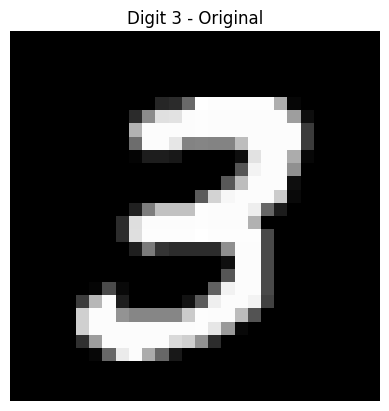

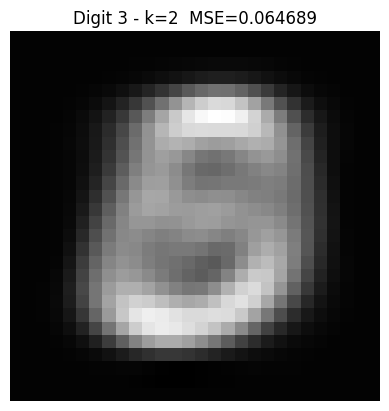

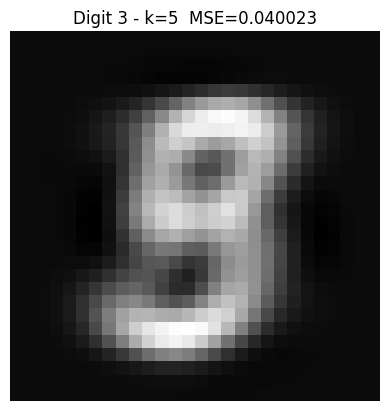

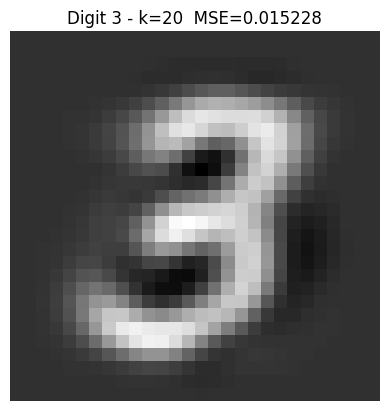

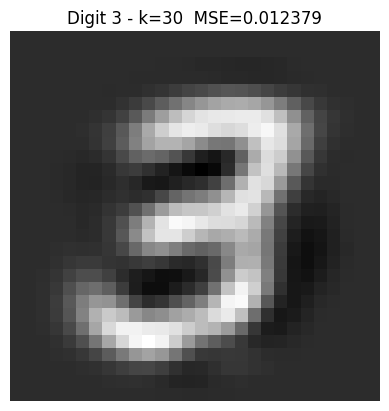

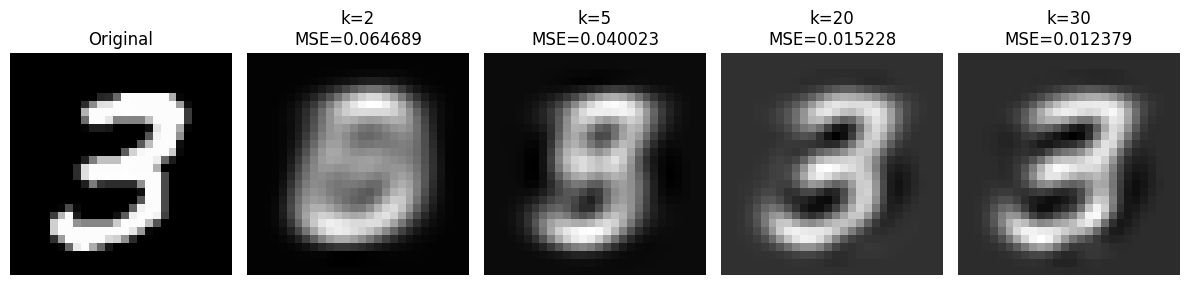

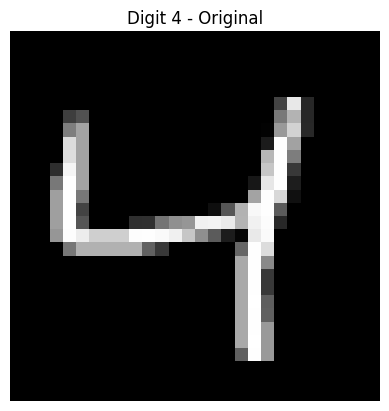

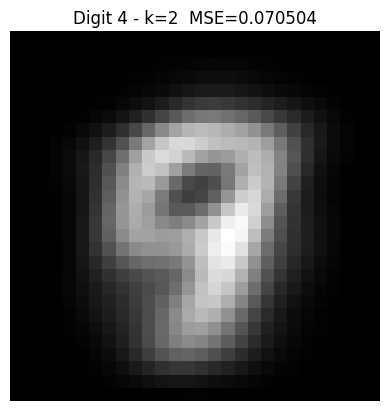

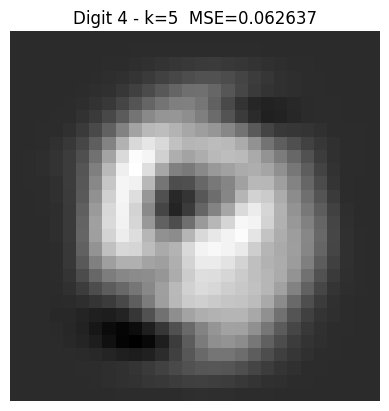

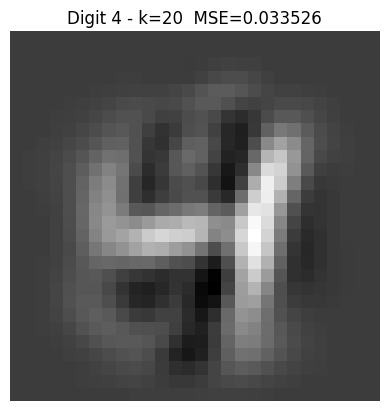

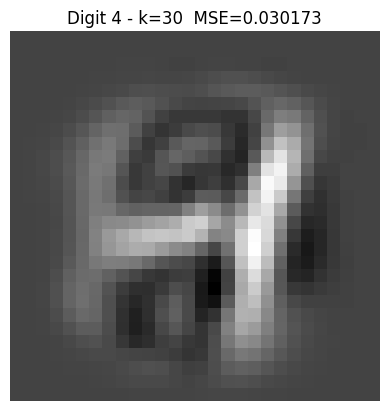

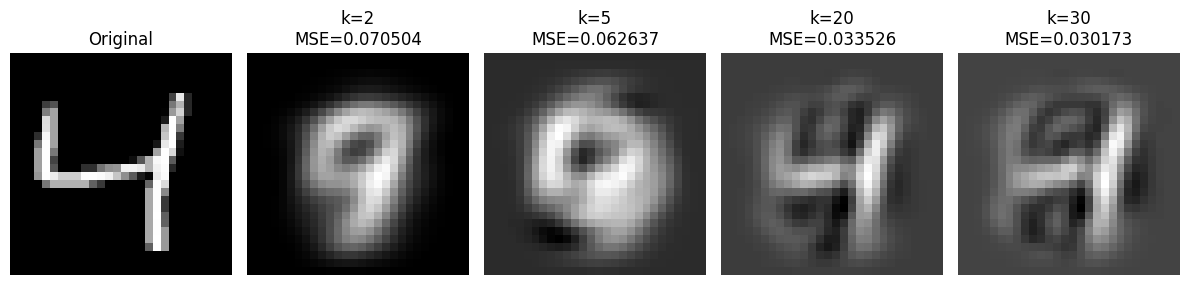

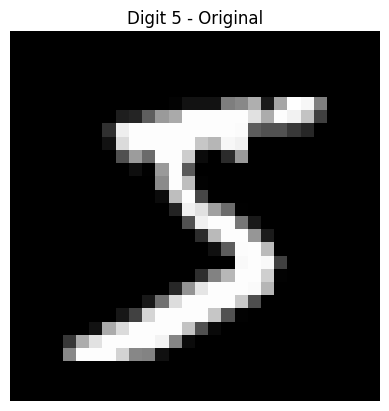

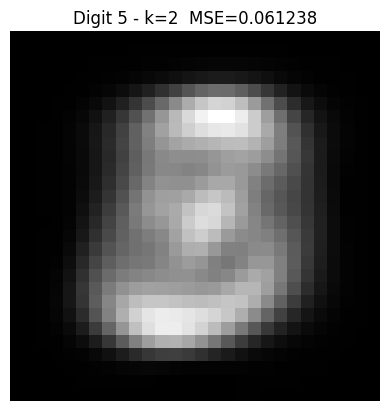

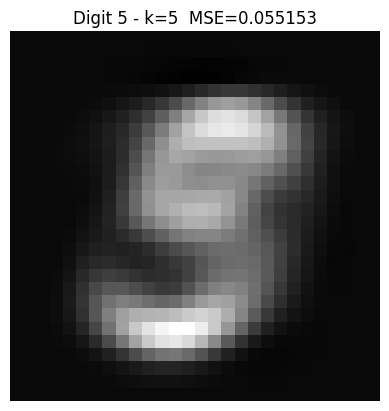

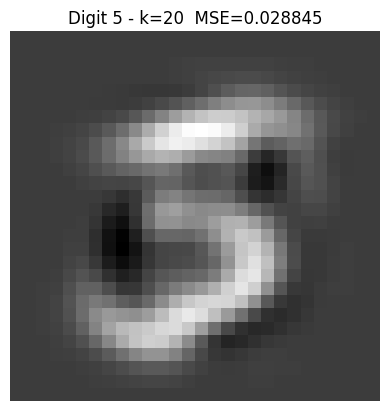

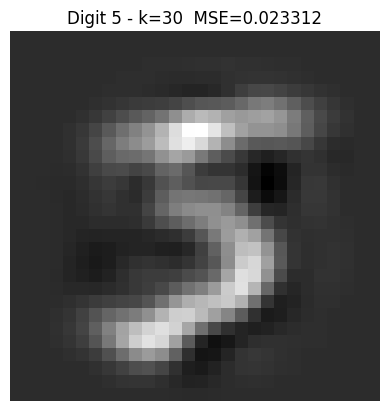

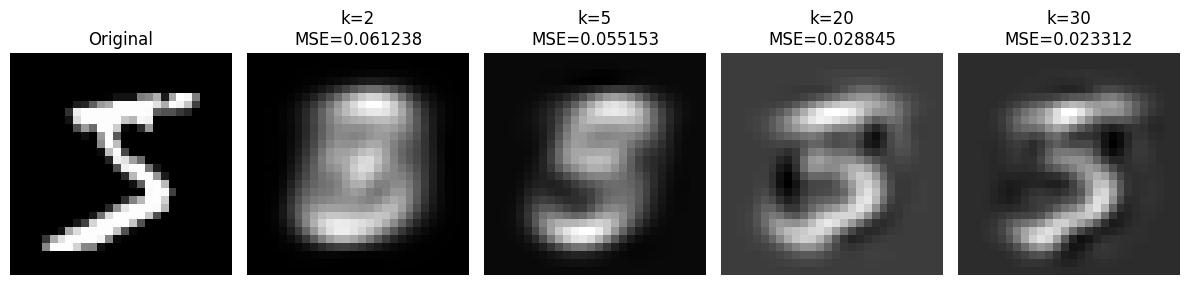

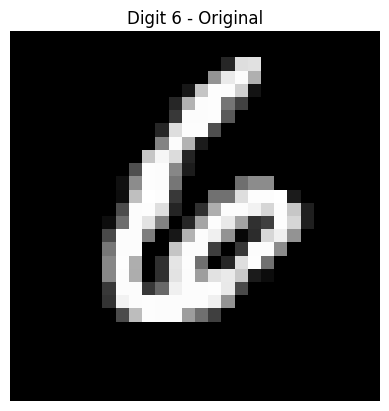

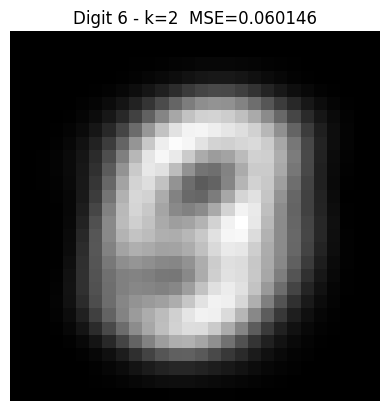

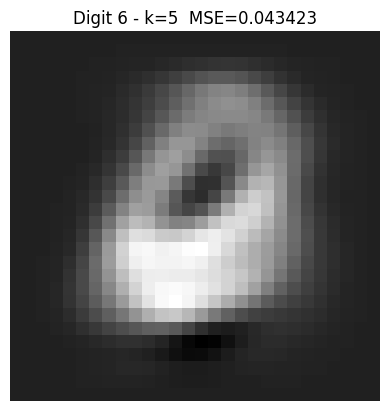

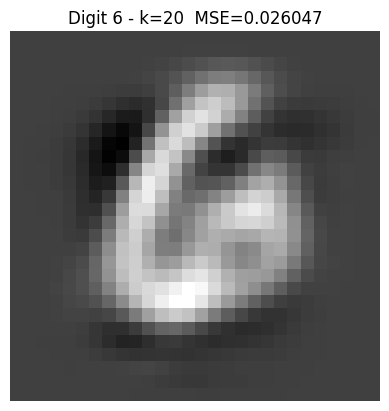

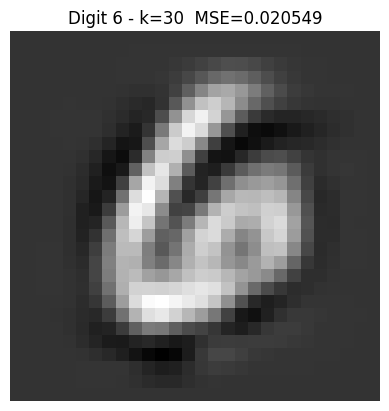

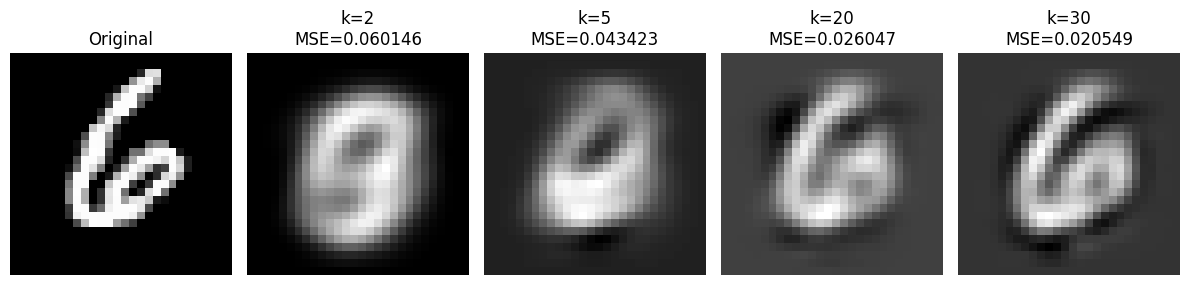

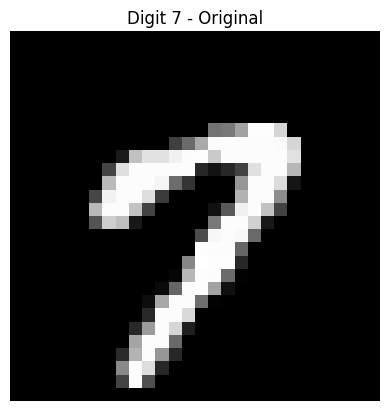

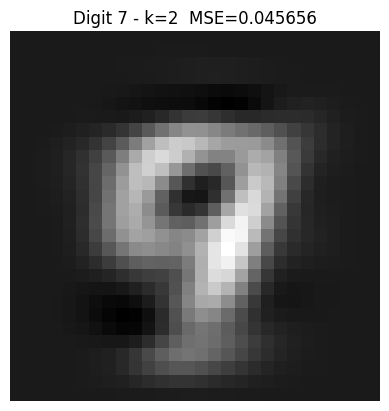

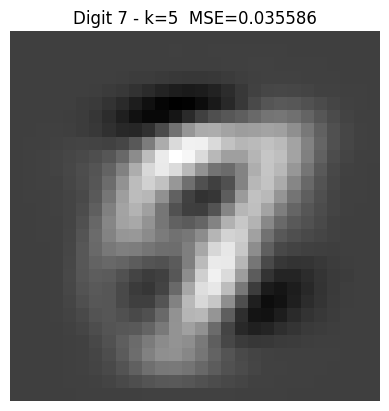

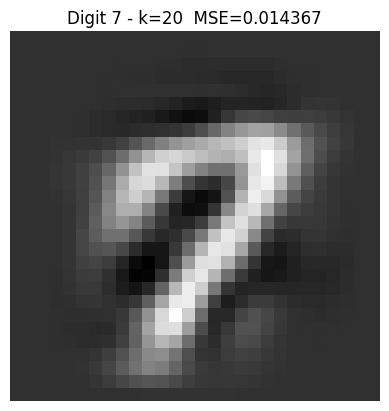

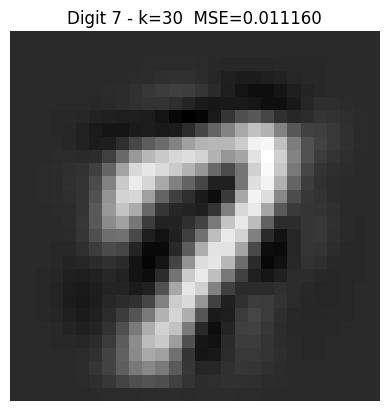

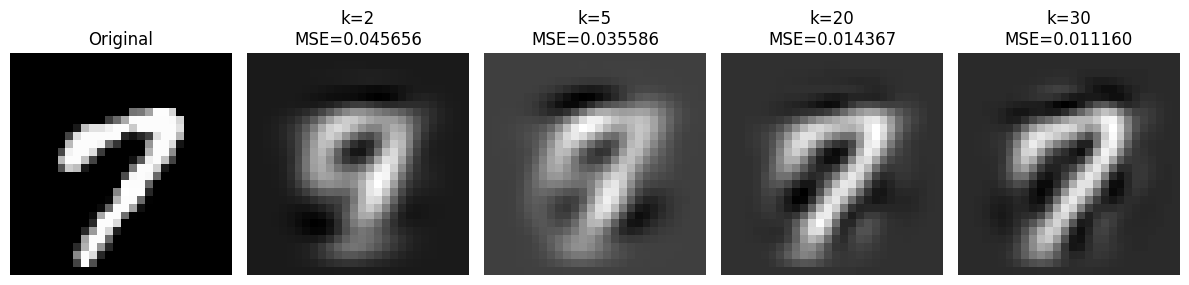

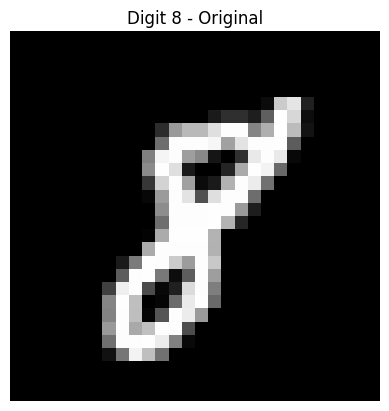

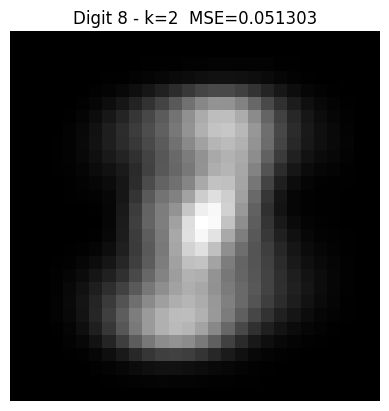

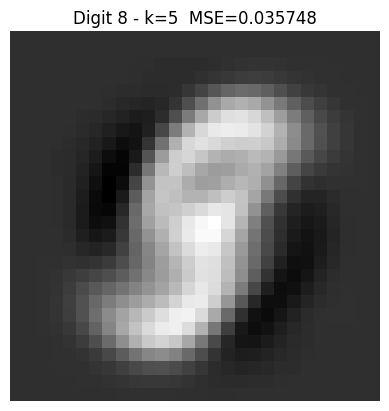

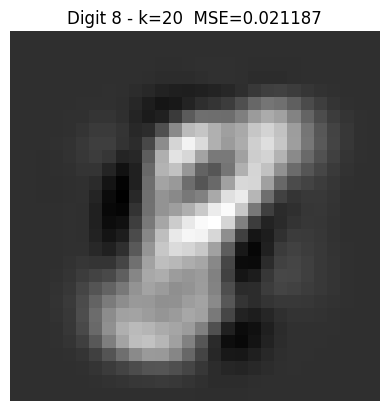

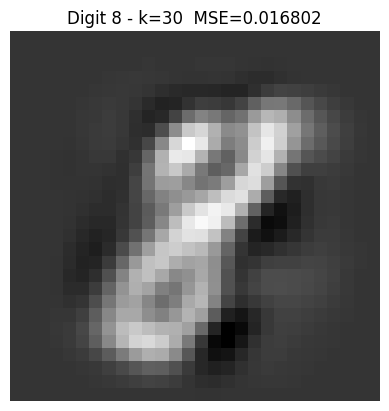

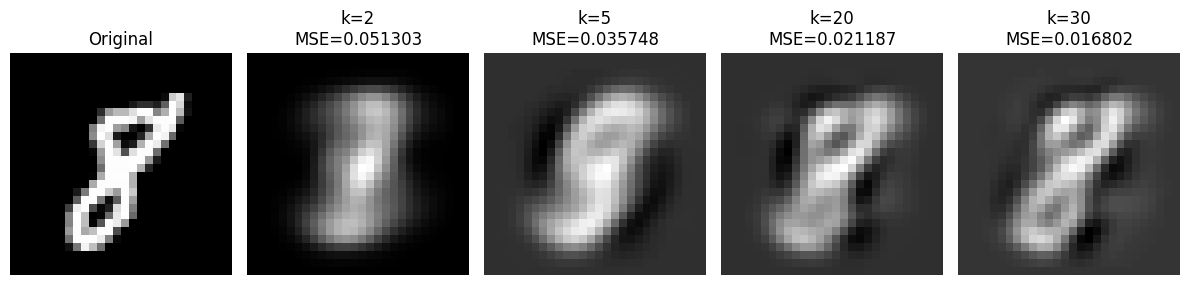

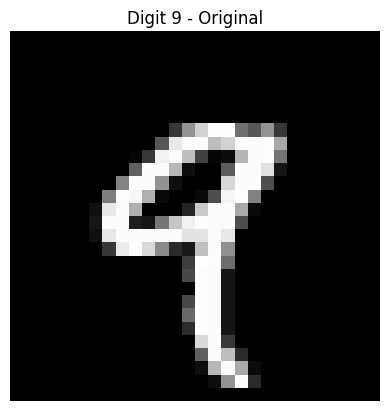

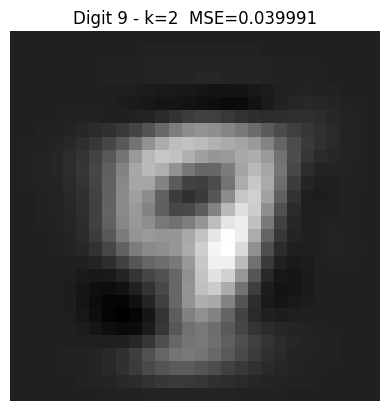

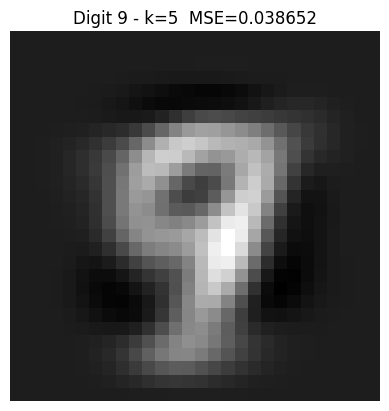

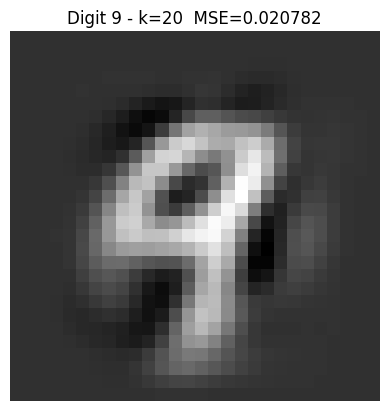

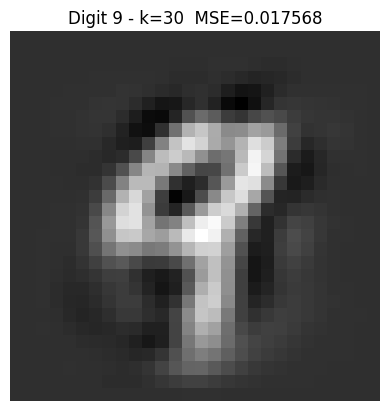

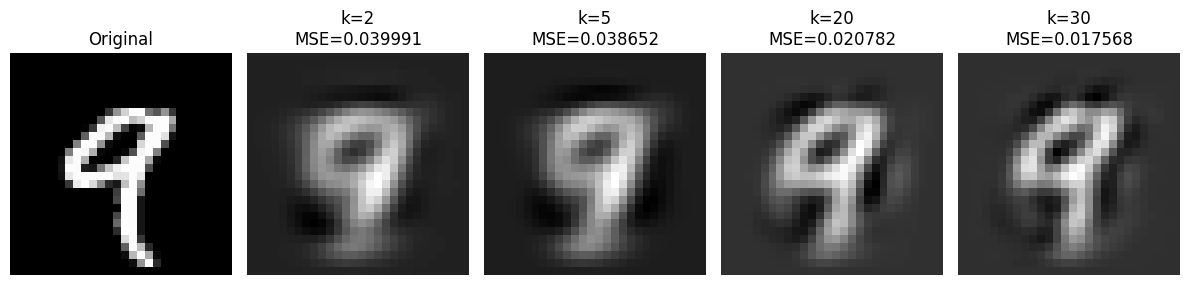

Saved Part 2 MSE CSV: PCA_HW2_results_20251006_145357/part2_mse_summary.csv


In [8]:
Ks = [2, 5, 20, 30]
mse_csv = os.path.join(ROOT, "part2_mse_summary.csv")

# Write CSV header
with open(mse_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["digit", "k", "MSE"])

# Process each digit 0..9
per_digit_grid_paths = []   # store grid path for each digit for later mega grid
orig_imgs = []              # store original 28x28 for mega grid
recon_imgs_all = []         # list of dicts per digit, mapping k-> image

for digit in range(10):
    # Select first occurrence of this digit
    idx = np.where(y_train == digit)[0][0]
    sample = x_train[idx]                     # (784,)
    original_img = sample.reshape(28, 28)

    # Folder per digit
    digit_dir = os.path.join(ROOT, f"digit_{digit}")
    os.makedirs(digit_dir, exist_ok=True)

    # Save original
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Digit {digit} - Original")
    plt.axis("off")
    orig_path = os.path.join(digit_dir, f"digit{digit}_original.png")
    plt.savefig(orig_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

    # Reconstruct and save for each k
    recon_dict = {}
    mses = {}
    for k in Ks:
        recon_img, mse = reconstruct_with_k(sample, k, mean_vec, components_30)
        recon_dict[k] = recon_img
        mses[k] = mse

        plt.imshow(recon_img, cmap="gray")
        plt.title(f"Digit {digit} - k={k}  MSE={mse:.6f}")
        plt.axis("off")
        out_path = os.path.join(digit_dir, f"digit{digit}_k{k}.png")
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()

        # Log MSE to CSV
        with open(mse_csv, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([digit, k, mse])

    # Save 1x5 grid per digit: Original, k=2, k=5, k=20, k=30
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    col_titles = ["Original", "k=2", "k=5", "k=20", "k=30"]
    imgs = [original_img, recon_dict[2], recon_dict[5], recon_dict[20], recon_dict[30]]

    for ax, img, title in zip(axes, imgs, col_titles):
        ax.imshow(img, cmap="gray")
        if title == "Original":
            ax.set_title(title)
        else:
            k_val = int(title.split('=')[1])
            ax.set_title(f"{title}\nMSE={mses[k_val]:.6f}")
        ax.axis("off")

    grid_path = os.path.join(digit_dir, f"digit{digit}_grid.png")
    plt.tight_layout()
    plt.savefig(grid_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

    per_digit_grid_paths.append(grid_path)
    orig_imgs.append(original_img)
    recon_imgs_all.append(recon_dict)

print("Saved Part 2 MSE CSV:", mse_csv)


7)  One “Mega Grid” (10 rows × 5 cols)

Each row is a digit 0..9, columns: Original | k=2 | k=5 | k=20 | k=30 with MSE annotations.

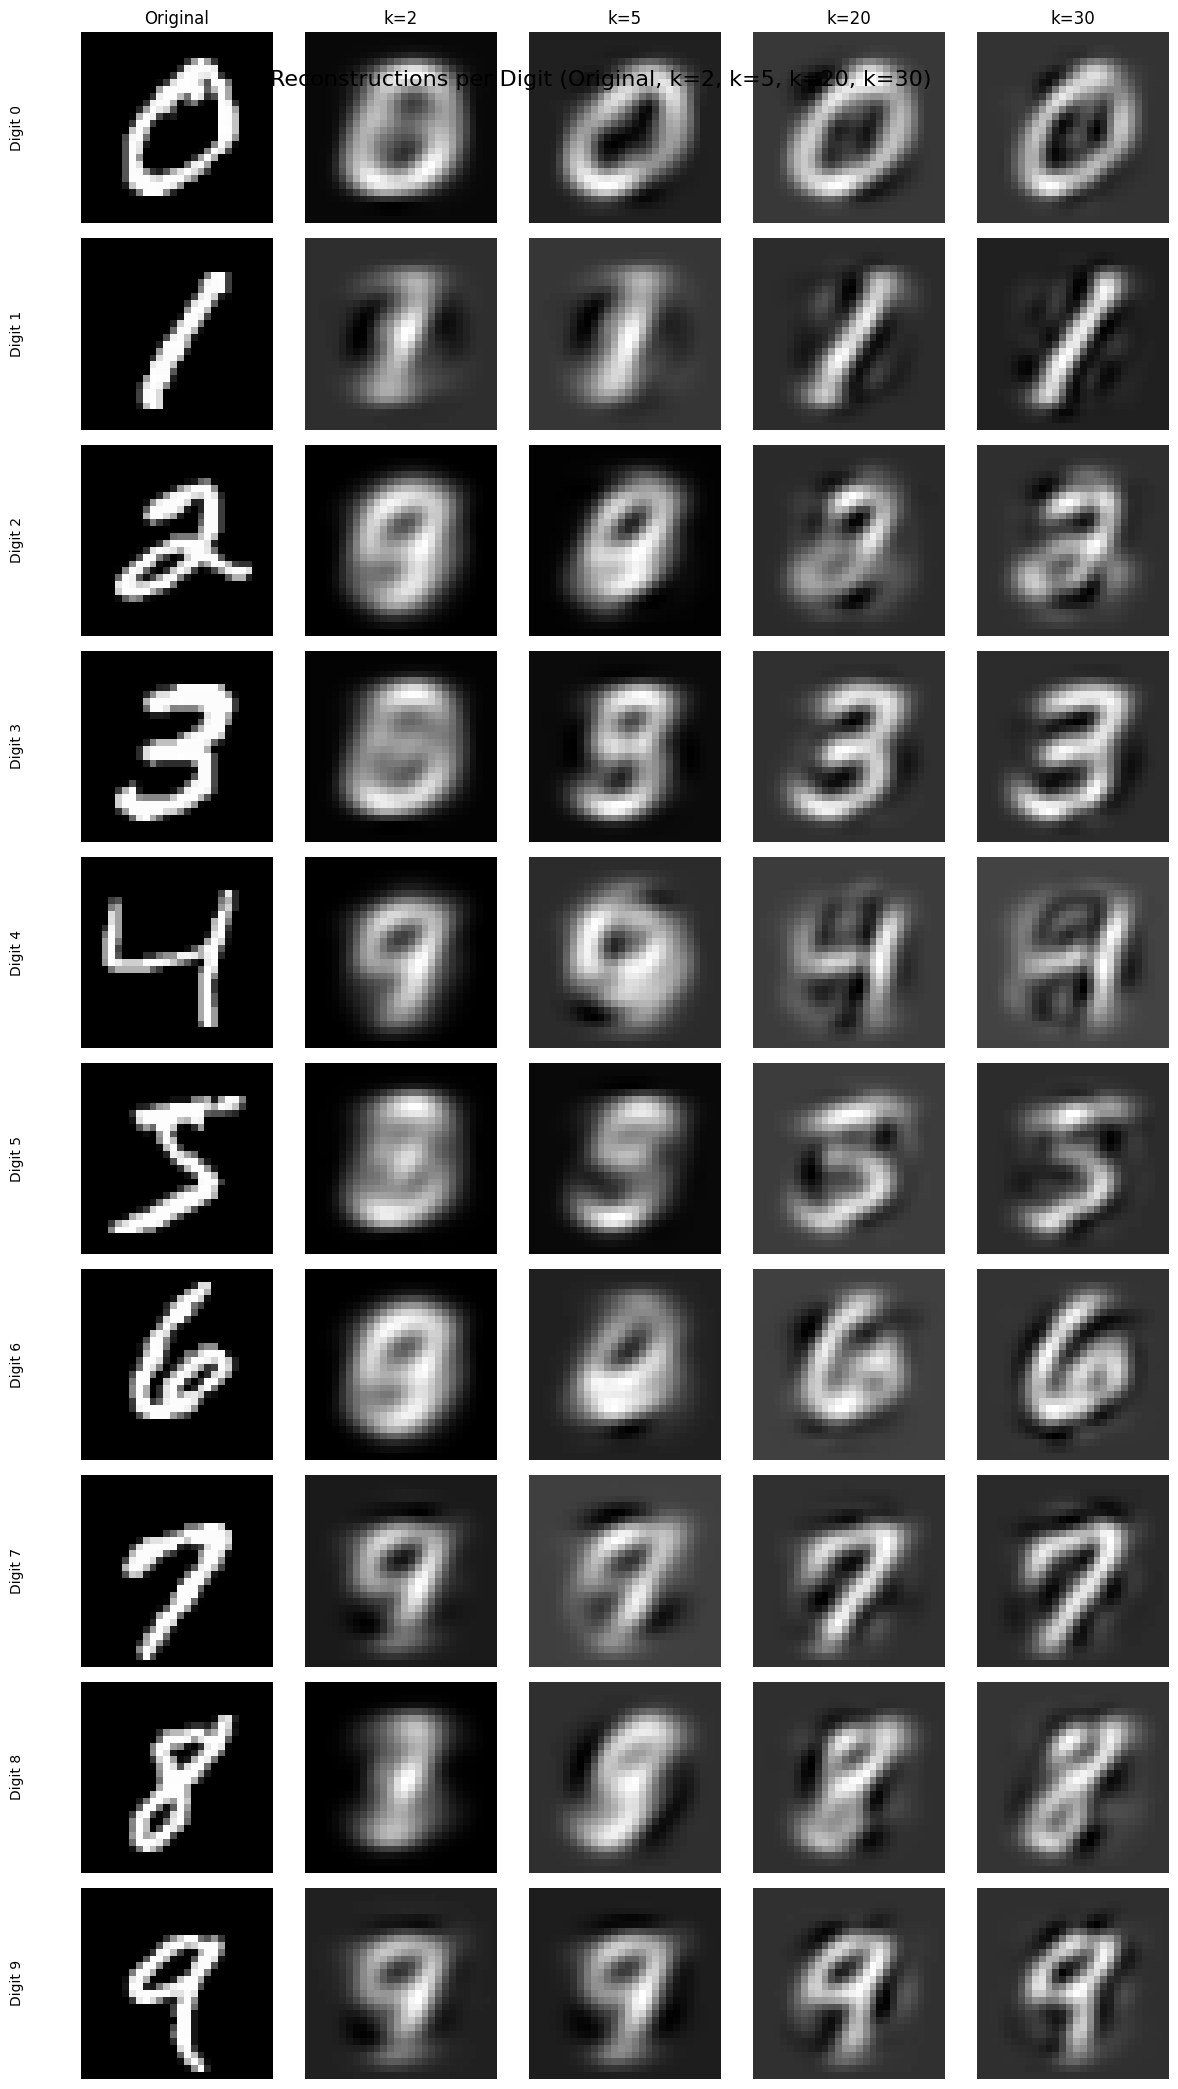

Saved mega grid: PCA_HW2_results_20251006_145357/part2_mega_grid_all_digits.png


In [9]:
# Build a 10x5 mega grid
fig, axes = plt.subplots(10, 5, figsize=(12, 22))
fig.suptitle("Reconstructions per Digit (Original, k=2, k=5, k=20, k=30)", y=0.92, fontsize=16)

for digit in range(10):
    # Find sample again (same as before)
    idx = np.where(y_train == digit)[0][0]
    sample = x_train[idx]
    original_img = orig_imgs[digit]
    recon_dict = recon_imgs_all[digit]

    # Recompute MSEs for titles (tiny overhead)
    mses = {}
    for k in [2,5,20,30]:
        _, mse = reconstruct_with_k(sample, k, mean_vec, components_30)
        mses[k] = mse

    # Column images
    row_imgs = [original_img, recon_dict[2], recon_dict[5], recon_dict[20], recon_dict[30]]
    for col, img in enumerate(row_imgs):
        ax = axes[digit, col]
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if digit == 0:  # top row column headers
            ax.set_title(["Original", "k=2", "k=5", "k=20", "k=30"][col])

        # Add MSE under recon columns
        if col > 0:
            k_here = [None, 2, 5, 20, 30][col]
            ax.set_xlabel(f"MSE={mses[k_here]:.6f}", fontsize=8, labelpad=4)

        # Add row label on left side
        if col == 0:
            ax.text(-0.3, 0.5, f"Digit {digit}", transform=ax.transAxes,
                    fontsize=10, va="center", ha="right", rotation=90)

mega_path = os.path.join(ROOT, "part2_mega_grid_all_digits.png")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(mega_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

print("Saved mega grid:", mega_path)


8)  Zip & Download Everything

In [11]:
# Zip the entire results folder for easy download
zip_path = f"{ROOT}.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)
shutil.make_archive(ROOT, 'zip', ROOT)
print("Zipped results at:", zip_path)




Zipped results at: PCA_HW2_results_20251006_145357.zip
